# Self employment effect -- Bayesian take

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Self employed in 2019 -- **chesefin** 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

In [1]:
from pathlib import Path
from dataclasses import dataclass, fields
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit
import matplotlib.pyplot as plt

import jax.numpy as jnp
import numpyro as pyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
from jax.scipy.special import expit, erf

from scipy.stats import norm, mstats
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegressionCV
from sklearn.base import BaseEstimator
from sklearn.kernel_approximation import Nystroem

from lightgbm import LGBMClassifier

from reed import drop_missing_treatment_or_outcome, Model, transform_outcome
from direct_regression import seperate_and_transform_data, print_unconditional_effects

pyro.enable_x64()
%matplotlib inline

## Analysis Parameters

In [2]:
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

#configuration_name = 'default'
outcome = 'chsefin'
treatment = 'redufl'
test = False
data_file = Path("~/Code/re-education/data/all_lasso_selected_100_restricted.csv")
outc_file = Path("~/Code/re-education/data/transition_self_employed.csv")

## Load the data

Dropped 0 rows missing treatment or outcome.


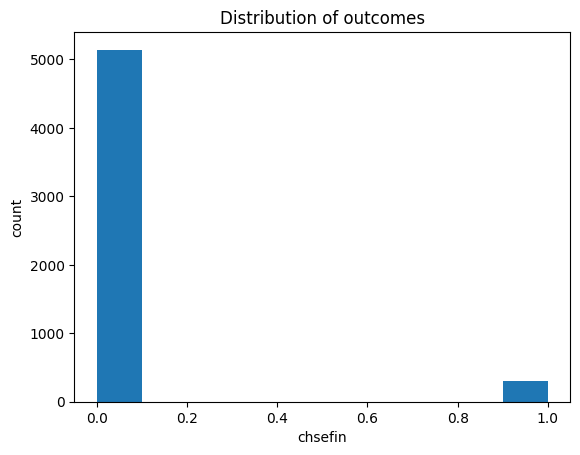

In [3]:
data = data_load_func(data_file)
target = data_load_func(outc_file)
data = data.join(target)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome], False, False)

    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

## Prepare data for modeling

- split into treated/control
- impute missing values and scale
- separate features from outcomes&treatments



In [4]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ", X0.shape)
print("Treated data dimensions:", X1.shape)

Control data dimensions:  (4043, 91)
Treated data dimensions: (1398, 91)


## Compute unconditional/unadjusted estimate of treatment effect

In [5]:
print_unconditional_effects(data, treatment, y0, y1, logodds=True)

Proportion Treated:26%
Average outcome under Control:0.05±0.00
Average outcome under Treatment:0.08±0.01
Unadjusted treatment estimate (log-odds) 0.46
Unadjusted treatment estimate 0.03


## Statsmodels

### GLM S-learner -- Logit and Probit models

In [6]:
Xt = np.hstack((t[:, np.newaxis], X))
Xt = pd.DataFrame(data=Xt, columns=["treatment"] + features)
#Xt["treatment"] = Xt["treatment"].astype("category")
tind = list(Xt.columns).index("treatment")

print("Probit model")
glmp = Probit(y, sm.add_constant(Xt))
resp = glmp.fit(maxiter=500, method="bfgs")
mresp = resp.get_margeff()
ate_glmp = mresp.margeff[tind]
ci_glmp = mresp.conf_int()[tind]
print(f"Marginal effect: {ate_glmp:.4f} [{ci_glmp[0]:.4f}, {ci_glmp[1]:.4f}]")

print("\nLogit model")
glml = Logit(y, sm.add_constant(Xt))
resl = glml.fit(maxiter=500, method="bfgs")
mresl = resl.get_margeff()
ate_glml = mresl.margeff[tind]
ci_glml = mresl.conf_int()[tind]
print(f"Marginal effect: {ate_glml:.4f} [{ci_glml[0]:.4f}, {ci_glml[1]:.4f}]")

Probit model
Optimization terminated successfully.
         Current function value: 0.190554
         Iterations: 131
         Function evaluations: 132
         Gradient evaluations: 132
Marginal effect: 0.0131 [0.0000, 0.0263]

Logit model
Optimization terminated successfully.
         Current function value: 0.190973
         Iterations: 250
         Function evaluations: 251
         Gradient evaluations: 251
Marginal effect: 0.0122 [-0.0009, 0.0253]


## Train a propensity score model

This should help with bias in estimating treatment effects with Bayesian models.

See:

[Hahn, P.R., Murray, J.S. and Carvalho, C.M., 2020. Bayesian regression tree models for causal inference: Regularization, confounding, and heterogeneous effects (with discussion). Bayesian Analysis, 15(3), pp.965-1056.](https://projecteuclid.org/journals/bayesian-analysis/volume-15/issue-3/Bayesian-Regression-Tree-Models-for-Causal-Inference--Regularization-Confounding/10.1214/19-BA1195.pdf)


For more information.

In [7]:
linear_prop = LogisticRegressionCV(max_iter=500)
nonlin_prop = GridSearchCV(
    LGBMClassifier(),
    param_grid={"learning_rate": [1e-3, 1e-2, 5e-2, 0.1, 0.5]},
    scoring="neg_log_loss",
    n_jobs=-1
)


@dataclass
class ScoreMap:
    sfn: callable
    sres: list
        
    def __init__(self, sfn):
        self.sfn = sfn
        self.sres = []

        
@dataclass
class Scores:
    accuracy: ScoreMap
    baccuracy: ScoreMap
    logloss: ScoreMap
    
    def __init__(self):
        self.accuracy = ScoreMap(sfn=accuracy_score)
        self.baccuracy = ScoreMap(sfn=balanced_accuracy_score)
        self.logloss = ScoreMap(sfn=log_loss)

        
@dataclass
class ModelMap:
    model: BaseEstimator
    propensity: np.ndarray
    scores: Scores
    
    def __init__(self, model):
        self.model = model
        self.propensity = np.zeros(len(t))  # zeros_like becomes immutable?
        self.scores = Scores()
        
    def set_ps(self, ind, p):
        self.propensity[ind] = p
        

pmodels = {
    "logistic": ModelMap(model=linear_prop),
    "gbc": ModelMap(model=nonlin_prop)
}

In [8]:
for i, (tr_ind, ts_ind) in enumerate(StratifiedKFold(n_splits=5, shuffle=True).split(X, t)):
    t_tr, t_ts = t[tr_ind], t[ts_ind]
    X_tr, X_ts = X[tr_ind], X[ts_ind]
    
    print(f"Round {i}")
    for name, props in pmodels.items():
        props.model.fit(X_tr, t_tr)
        p = props.model.predict_proba(X_ts)[:, 1]
        t_hat = (p > 0.5).astype(int)
        
        props.scores.logloss.sres.append(props.scores.logloss.sfn(t_ts, p))
        props.scores.baccuracy.sres.append(props.scores.baccuracy.sfn(t_ts, t_hat))
        props.scores.accuracy.sres.append(props.scores.accuracy.sfn(t_ts, t_hat))
        
        props.set_ps(ts_ind, p)

Round 0
Round 1
Round 2
Round 3
Round 4


In [9]:
for name, props in pmodels.items():
    for f in fields(props.scores):
        score = getattr(props.scores, f.name)
        smean, sstd = np.mean(score.sres), np.std(score.sres, ddof=1)
        print(f"{name}-{f.name}: {smean:.4f} ({sstd:.4f})")

logistic-accuracy: 0.7425 (0.0043)
logistic-baccuracy: 0.5164 (0.0180)
logistic-logloss: 0.5177 (0.0032)
gbc-accuracy: 0.7399 (0.0086)
gbc-baccuracy: 0.5358 (0.0229)
gbc-logloss: 0.5189 (0.0092)


In [10]:
# There is not much difference in model performance, so go with logistic model for simplicity
p = linear_prop.fit(X, t).predict(X)
#p = pmodels["gbc"].propensity

## Hierarchical Bayesian Model

This model takes the following form and prior settings,

$$
\begin{align}
    \{\lambda_0, \lambda_x, \lambda_{\pi}\} &\sim \textrm{Uniform}(0, 100) \\
    \{\lambda_t, \lambda_{tx}\} &\sim \textrm{Uniform}(0, 1000) \\
    w_0 &\sim \mathcal{N}(0, \lambda_0^2) \\
    w_\pi &\sim \mathcal{N}(0, \lambda_\pi^2) \\
    \mathbf{w}_x &\sim \mathcal{N}(0, \lambda_x^2 \mathbf{I}_d) \\
    w_t &\sim \mathcal{N}(0, \lambda_t^2) \\
    \mathbf{w}_{tx} &\sim \mathcal{N}(0, \lambda_{tx}^2 \mathbf{I}_d) \\
    y_i &\sim \mathrm{Bernoulli}\!\left(\mu(\mathbf{x}_i, t_i, \pi_i)\right) \\
    \mu(\mathbf{x}_i, t_i, \pi_i) &= \Phi\!\left(\rho(\mathbf{x}_i, \pi_i) + t_i \cdot \tau(\mathbf{x}_i)\right) \\
    \tau(\mathbf{x}_i) &= \mathbf{w}_{tx}^\top\mathbf{x}_i + w_t\\
    \rho(\mathbf{x}_i, \pi_i) &= w_0 + w_\pi \pi_i + \mathbf{w}_x^\top\mathbf{x}_i\\
\end{align}
$$
Where $\Phi(z)$ is a logistic or Normal CDF (inverse probit) function. This explicitly models and interaction term, and can automatically regularise this term. This effectively allows the model to interpolate between an S and T-learner.

Since this is no longer a linear model, we have to rely on *partial effects* to compute the ATE,
$$
\begin{align}
    \hat{\textrm{ATE}} = \sum_{i=1}^n \mu(\mathbf{x}_i, 1, \pi_i) - \mu(\mathbf{x}_i, 0, \pi_i).
\end{align}
$$
See [2] equation 17.8 for more detail. Unfortunately, we lose the nice linear separation between the prognostic and treatment models. 

For ideas about choice of prior, we should refer to:

[1] Gelman, A. (2006). Prior distributions for variance parameters in hierarchical models. Bayesian analysis, 1(3), 515-534.

[2] Wooldridge, J.M., 2015. Introductory econometrics: A modern approach. Cengage learning.

### Set up the model

Probability transformation (inverse link) functions

In [11]:
def iprobit(x):
    p = 0.5 * (1 + erf(x / jnp.sqrt(2)))
    return p
    

def ilogit(x):
    p = expit(x)
    return p


def icloglog(x):
    p = 1 - jnp.exp(- jnp.exp(x))
    return p


TFM_FUNCTION = ilogit

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


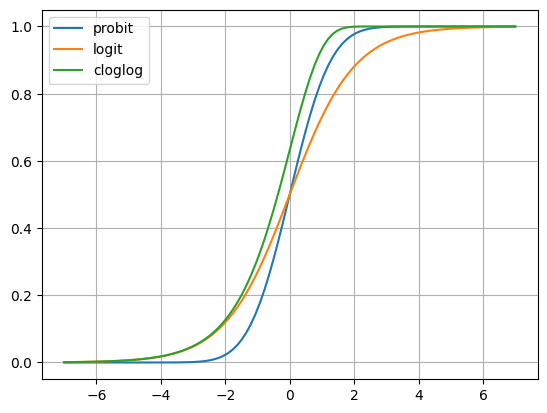

In [12]:
f = np.linspace(-7, 7, 100)
for name, tfm in {"probit": iprobit, "logit": ilogit, "cloglog": icloglog}.items():
    pp = tfm(f)
    plt.plot(f, pp, label=name)

plt.legend()
plt.grid()
plt.show()

In [13]:
def predict(w_0, w_t, w_x, w_tx, w_p, xp, xt, t, p):
    f = prognostic(w_0, w_x, w_p, xp, p) + t * ite(w_tx, w_t, xt)
    pf = TFM_FUNCTION(f)
    return pf


def prognostic(w_0, w_x, w_p, x, p):
    mu = w_0 + w_p * p + x @ w_x
    return mu


def ite(w_tx, w_t, x):
    tau = x @ w_tx + w_t
    return tau


def model_treatment_intersection(xp, xt, t, p, y):
    n, d = xp.shape
    assert(d == xt.shape[1])

    # Hyper Priors
    l_0 = pyro.sample("l_0", dist.Uniform(0, 100))
    l_x = pyro.sample("l_x", dist.Uniform(0, 100))
    l_p = pyro.sample("l_p", dist.Uniform(0, 100))
    l_t = pyro.sample("l_t", dist.Uniform(0, 1000))
    l_tx = pyro.sample("l_tx", dist.Uniform(0, 1000))
    
    # Priors
    p_wp = dist.Normal(0, l_p**2)
    p_w0 = dist.Normal(0, l_0**2)
    p_wx = dist.Normal(np.zeros(d), l_x**2 * np.ones(d))
    p_wt = dist.Normal(0, l_t**2)
    p_twx = dist.Normal(np.zeros(d), l_tx**2 * np.ones(d))
    
    # Model weights
    w_p = pyro.sample("propensity", p_wp)
    w_0 = pyro.sample("intercept", p_w0)
    w_t = pyro.sample("treatment", p_wt)
    w_x = pyro.sample("confounders", p_wx)
    w_tx = pyro.sample("intersection", p_twx)
    
    # Likelihood
    pf = predict(w_0, w_t, w_x, w_tx, w_p, xp, xt, t, p)
    
    with pyro.plate("data", n):
        likelihood = dist.Bernoulli(pf)
        y = pyro.sample("likelihood", likelihood, obs=y)

### Run MCMC inference to compute the posteriors

In [14]:
samples = 2000
warm_up = 1000

# Initialize No U-Turn Sampler
kernel = NUTS(model_treatment_intersection, max_tree_depth=8)
model_mcmc = MCMC(kernel, num_samples=samples, num_warmup=warm_up, num_chains=1)

# Run the sampler
rng_key = random.PRNGKey(0)
model_mcmc.run(rng_key, X, X, t, p, y)
model_mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [02:44<00:00, 18.26it/s, 48 steps of size 8.56e-02. acc. prob=0.72] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  confounders[0]      0.01      0.05      0.01     -0.06      0.08   2230.80      1.00
  confounders[1]     -0.04      0.05     -0.04     -0.11      0.04   2234.70      1.00
  confounders[2]      0.04      0.05      0.04     -0.02      0.12   2497.85      1.00
  confounders[3]      0.08      0.05      0.08      0.00      0.15   1943.79      1.00
  confounders[4]      0.03      0.04      0.03     -0.04      0.10   2400.12      1.00
  confounders[5]      0.04      0.04      0.03     -0.03      0.10   2198.43      1.00
  confounders[6]      0.03      0.04      0.03     -0.04      0.10   1606.48      1.00
  confounders[7]     -0.00      0.04     -0.00     -0.07      0.07   2695.38      1.00
  confounders[8]      0.06      0.04      0.07     -0.00      0.13   2002.54      1.00
  confounders[9]      0.02      0.05      0.02     -0.05      0.10   1645.81      1.00
 confounders[10]      0.01      0.05      

### Sample the ATE

In [15]:
hbr_samples = model_mcmc.get_samples()
w_0s = hbr_samples["intercept"]
w_ps = hbr_samples["propensity"]
w_ts = hbr_samples["treatment"]
w_xs = hbr_samples["confounders"]
w_txs = hbr_samples["intersection"]

ate_hlr_samples = np.zeros(samples)
score_samples = np.zeros(samples)

for s in range(samples):
    pf = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], w_ps[s], X, X, t, p)
    y_hat = (pf >= 0.5).astype(int)
    pf1 = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], w_ps[s], X, X, 1, p)
    pf0 = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], w_ps[s], X, X, 0, p)
    ate_hlr_samples[s] = (pf1 - pf0).mean()
    score_samples[s] = balanced_accuracy_score(y, y_hat)

ate_hlr = ate_hlr_samples.mean()
ci_hlr = mstats.mquantiles(ate_hlr_samples, prob=[0.025, 0.975])

print("Hierarchical Linear Regression")
print(f"  Balanced accuracy = {score_samples.mean():.4f} ({score_samples.std():.4f})")
print(f"  ATE: {ate_hlr:.4f}")
print(f"  CI (0.025, 0.975): [{ci_hlr[0]:.4f}, {ci_hlr[1]:.4f}]")

Hierarchical Linear Regression
  Balanced accuracy = 0.5016 (0.0016)
  ATE: 0.0131
  CI (0.025, 0.975): [-0.0004, 0.0285]


### Sample and display some posterior distributions

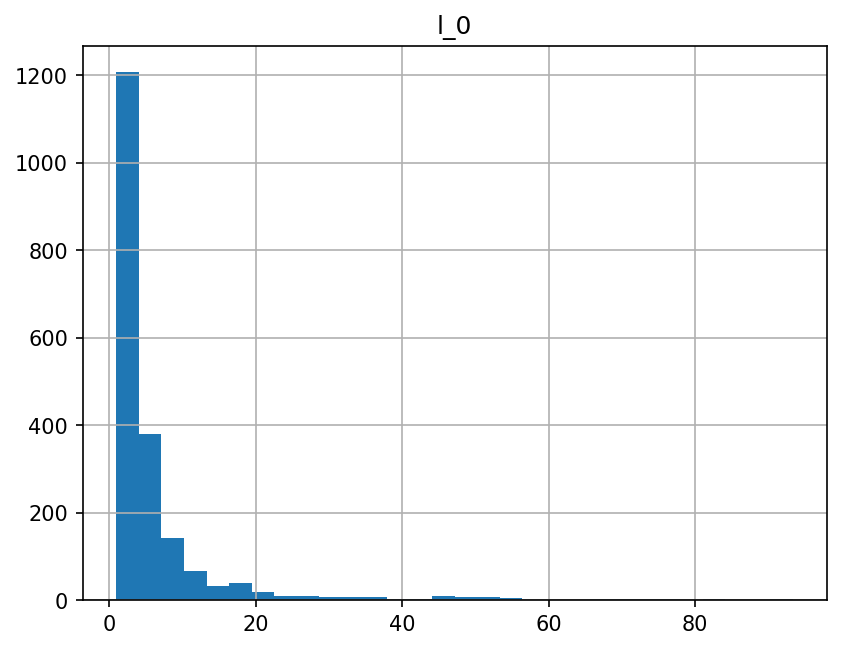

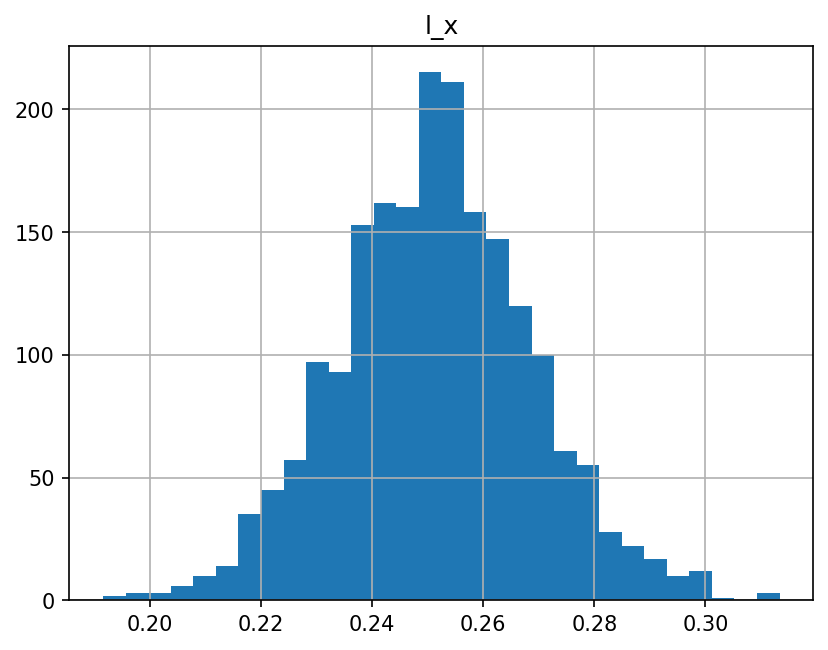

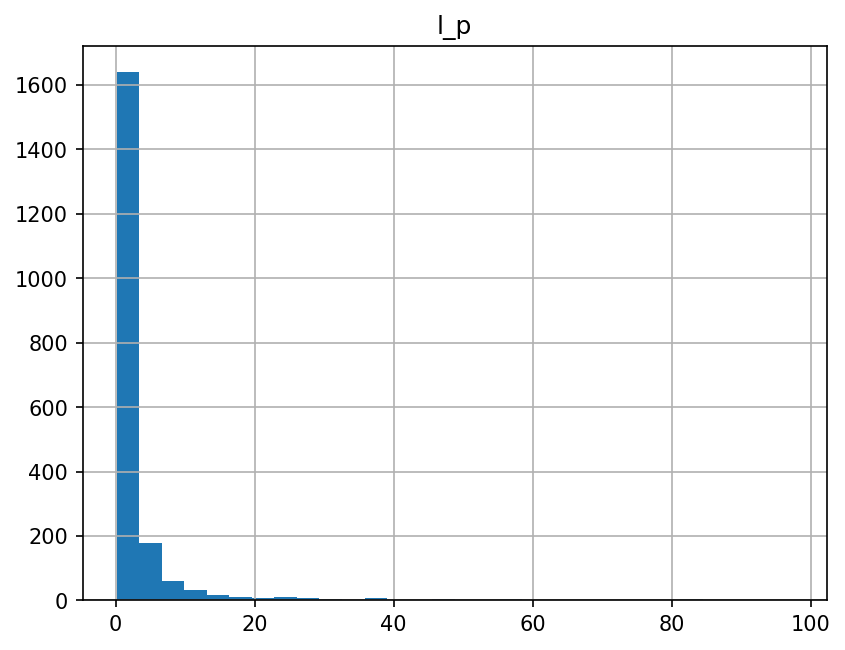

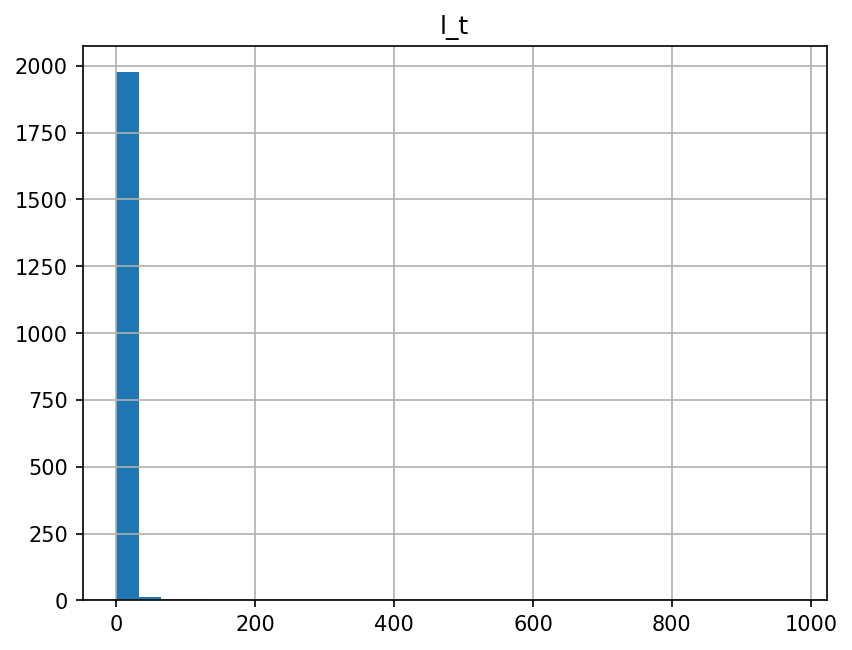

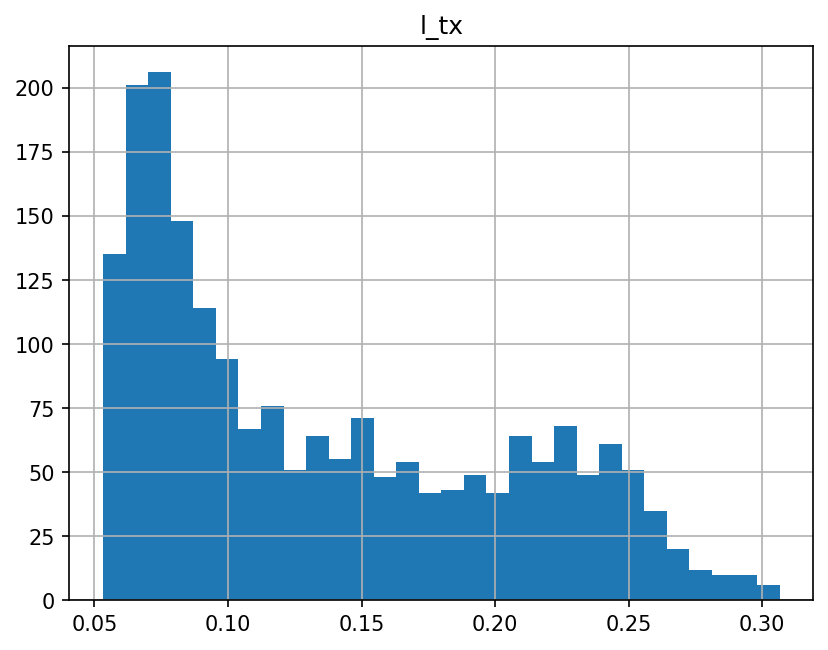

In [16]:
posteriors = ["l_0", "l_x", "l_p", "l_t", "l_tx"]
for name in posteriors:
    post = hbr_samples[name]
    plt.figure(dpi=150)
    plt.hist(post, bins=30)
    plt.title(name)
    plt.grid()
    plt.show()

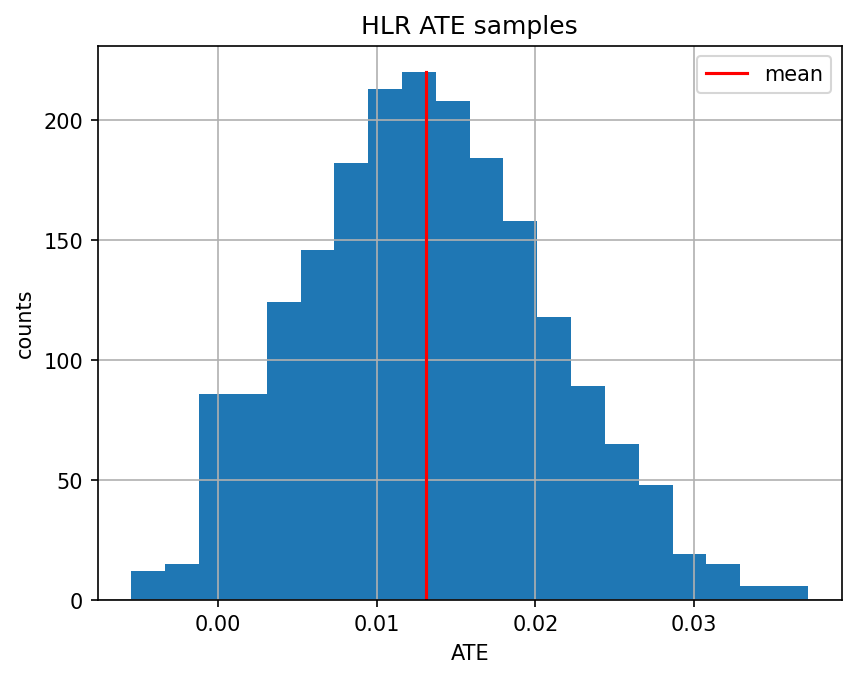

In [17]:
plt.figure(dpi=150)
cnt, *_ = plt.hist(ate_hlr_samples, bins=20)
plt.plot([ate_hlr, ate_hlr], [0, max(cnt)], 'r', label="mean")
plt.title("HLR ATE samples")
plt.xlabel("ATE")
plt.ylabel("counts")
plt.grid()
plt.legend()
plt.show()

# HLM with Nystroem features

This is the same model as the HLM as before, but with a non-linear Nystroem approximation applied to the controls that approximates a Gaussian process radial basis kernel. We use length-scales based on those found by the Gaussian process classifier for the income target.

The treatment and prognostic components now become:
$$
\begin{align}
    \tau(\mathbf{x}_i) &= \mathbf{w}_{tx}^\top\phi_{100}(\mathbf{x}_i) + w_t\\
    \rho(\mathbf{x}_i, \pi_i) &= w_0 + w_\pi \pi_i + \mathbf{w}_x^\top\phi_{10}(\mathbf{x}_i)\\
\end{align}
$$
where $\phi_l(\cdot)$ is the Nystroem basis where $l$ indicates the length scale. 

In [18]:
# RBF Features
gamma_p = 1 / 10**2
gamma_t = 1 / 100**2
Xrbfp = Nystroem(gamma=gamma_p, n_components=500).fit_transform(X)
Xrbft = Nystroem(gamma=gamma_t, n_components=500).fit_transform(X)

# Run the sampler
rng_key = random.PRNGKey(0)
model_mcmc.run(rng_key, Xrbfp, Xrbft, t, p, y)
model_mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [55:52<00:00,  1.12s/it, 127 steps of size 4.64e-02. acc. prob=0.89]  



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   confounders[0]      0.63      1.07      0.61     -1.26      2.26   2290.76      1.00
   confounders[1]      0.47      1.05      0.46     -1.30      2.16   2209.82      1.00
   confounders[2]     -0.38      1.11     -0.38     -2.35      1.29   2914.29      1.00
   confounders[3]     -0.42      1.07     -0.42     -2.13      1.44   3076.18      1.00
   confounders[4]     -0.26      1.07     -0.28     -1.76      1.69   2048.76      1.00
   confounders[5]     -0.02      1.05      0.00     -1.67      1.74   2466.55      1.00
   confounders[6]     -0.45      1.08     -0.44     -2.23      1.29   2196.39      1.00
   confounders[7]     -0.60      1.10     -0.60     -2.52      1.17   2388.91      1.00
   confounders[8]     -0.32      1.12     -0.34     -2.07      1.63   2674.56      1.00
   confounders[9]      0.19      0.96      0.19     -1.32      1.73   2266.15      1.00
  confounders[10]     -0.53    

In [19]:

gp_samples = model_mcmc.get_samples()
w_0s = gp_samples["intercept"]
w_ps = gp_samples["propensity"]
w_ts = gp_samples["treatment"]
w_xs = gp_samples["confounders"]
w_txs = gp_samples["intersection"]

ate_gp_samples = np.zeros(samples)
score_samples = np.zeros(samples)

for s in range(samples):
    pf = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], w_ps[s], Xrbfp, Xrbft, t, p)
    y_hat = (pf >= 0.5).astype(int)
    pf1 = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], w_ps[s], Xrbfp, Xrbft, 1, p)
    pf0 = predict(w_0s[s], w_ts[s], w_xs[s], w_txs[s], w_ps[s], Xrbfp, Xrbft, 0, p)
    ate_gp_samples[s] = (pf1 - pf0).mean()
    score_samples[s] = balanced_accuracy_score(y, y_hat)

ate_gp = ate_gp_samples.mean()
ci_gp = mstats.mquantiles(ate_gp_samples, prob=[0.025, 0.975])

print("Hierarchical approx GP Regression")
print(f"  Balanced accuracy = {score_samples.mean():.4f} ({score_samples.std():.4f})")
print(f"  ATE: {ate_gp:.4f}")
print(f"  CI (0.025, 0.975): [{ci_gp[0]:.4f}, {ci_gp[1]:.4f}]")

Hierarchical approx GP Regression
  Balanced accuracy = 0.5018 (0.0021)
  ATE: 0.0136
  CI (0.025, 0.975): [0.0002, 0.0275]


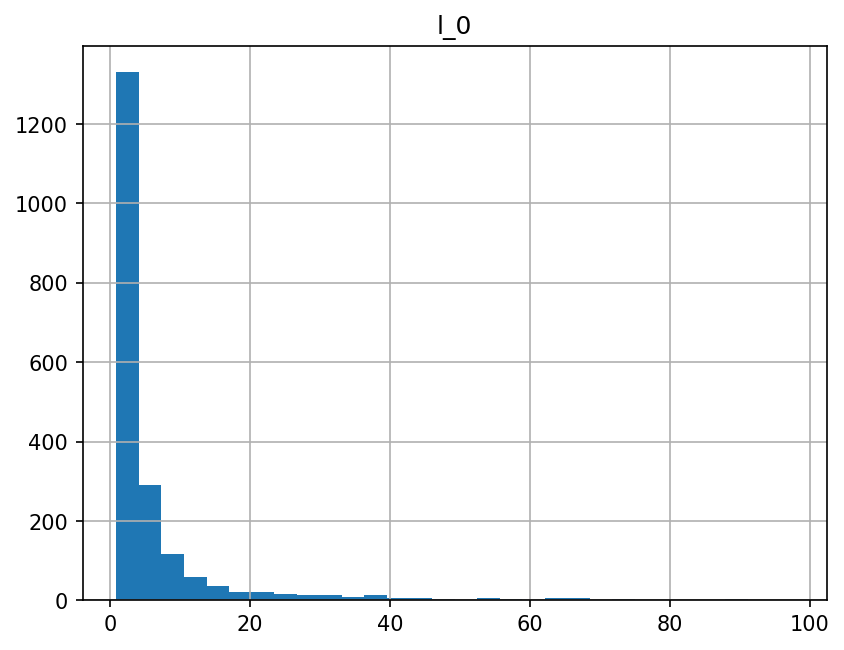

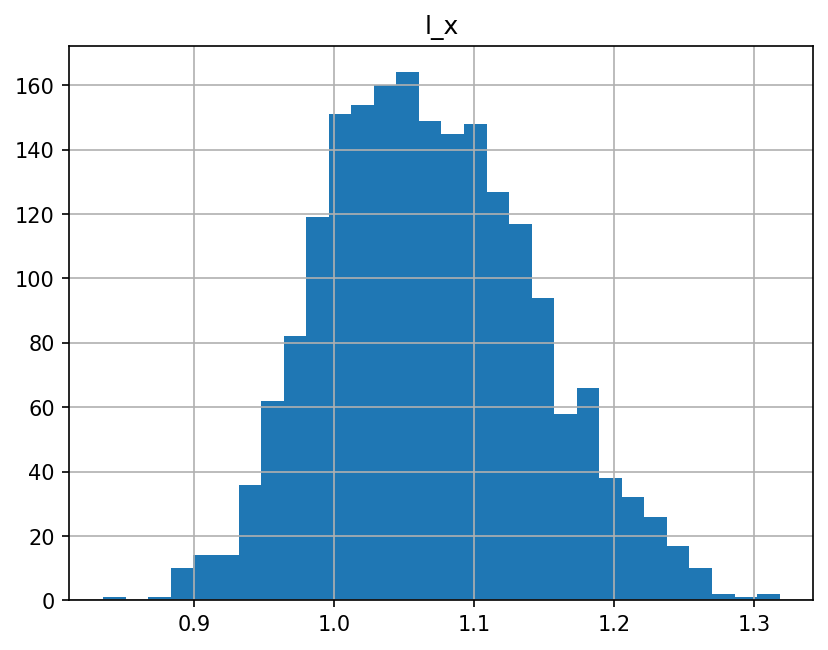

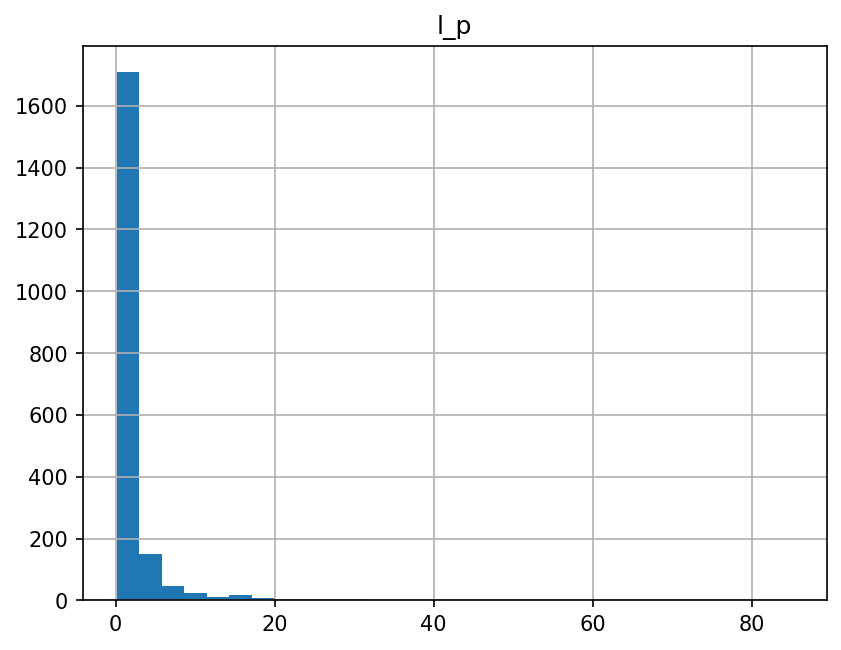

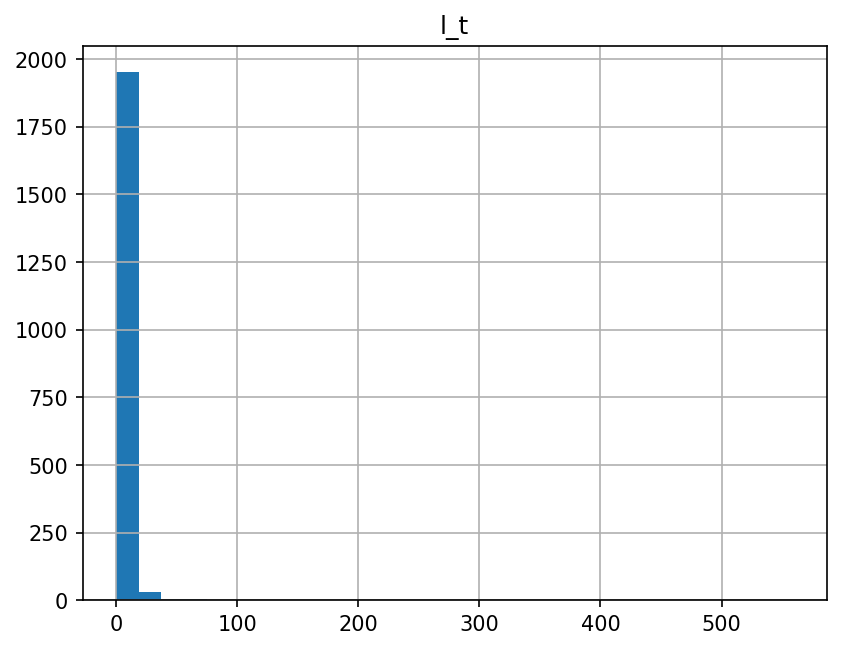

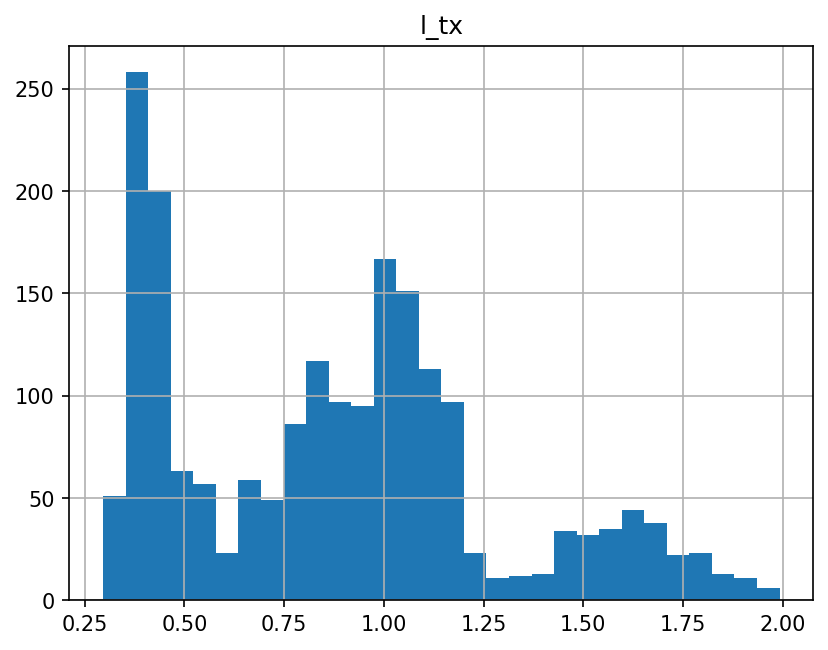

In [20]:
posteriors = ["l_0", "l_x", "l_p", "l_t", "l_tx"]
for name in posteriors:
    post = gp_samples[name]
    plt.figure(dpi=150)
    plt.hist(post, bins=30)
    plt.title(name)
    plt.grid()
    plt.show()

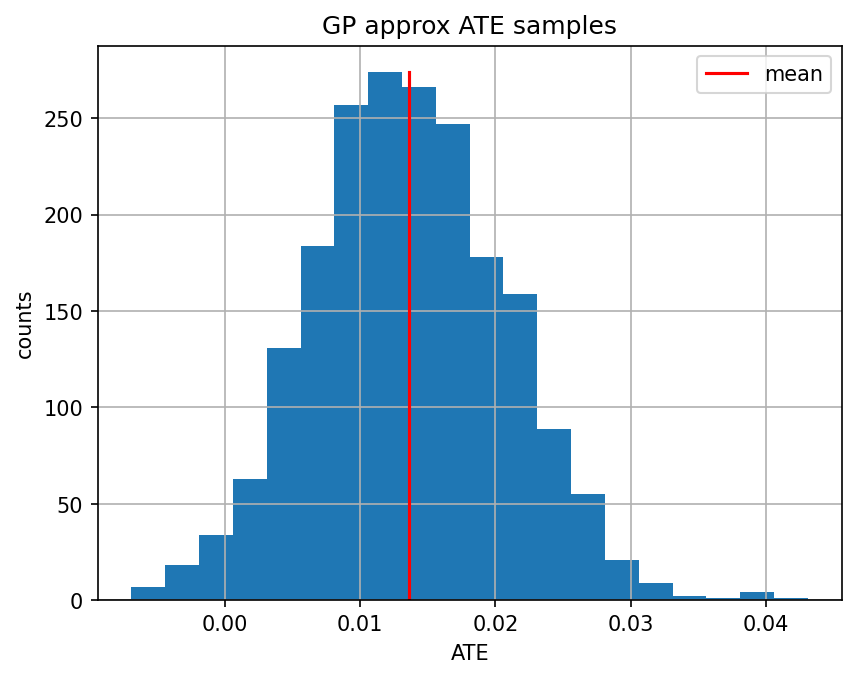

In [21]:
plt.figure(dpi=150)
cnt, *_ = plt.hist(ate_gp_samples, bins=20)
plt.plot([ate_gp, ate_gp], [0, max(cnt)], 'r', label="mean")
plt.title("GP approx ATE samples")
plt.xlabel("ATE")
plt.ylabel("counts")
plt.grid()
plt.legend()
plt.show()

## Plot ATE

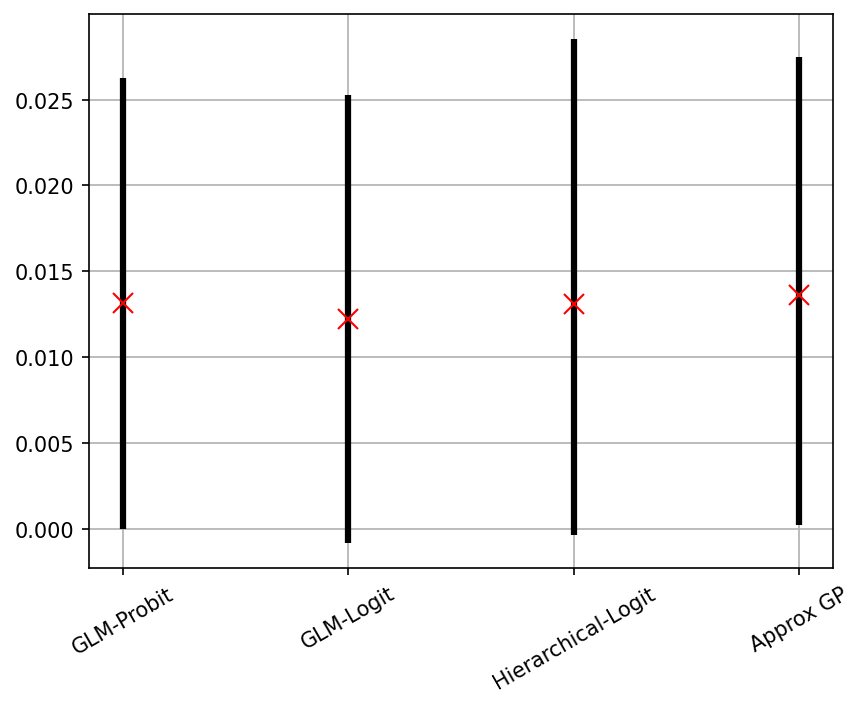

In [22]:
ate_labels = ["GLM-Probit", "GLM-Logit", "Hierarchical-Logit", "Approx GP"]
ate = [ate_glmp, ate_glml, ate_hlr, ate_gp]
ci = [ci_glmp, ci_glml, ci_hlr, ci_gp] 
ind = np.arange(len(ate))

plt.figure(dpi=150)
plt.vlines(ind, ymin=[c[0] for c in ci], ymax=[c[1] for c in ci], colors='k', linewidth=3)
plt.plot(ind, ate, 'rx', markersize=10)
plt.xticks(ind, labels=ate_labels, rotation=30)
plt.grid()
plt.show()